# Der Einstieg: Erkennung handgeschriebener Ziffern

Um einen Eindruck von der Leistungsfähigkeit Neuronaler Netze zu bekommen, beginnen wir mit einem konkreten Beispiel, das sich mit "herkömmlicher" Programmierung, also der Implementierung eines Algorithmus, nur sehr schwer lösen lässt.

Wir nehmen ein schon klassisches Beispiel, nämlich die Erkennung von handgeschriebenen Ziffern. Hiermit ist die automatische Verarbeitung vieler Vorgänge möglich, etwa die Auswertung von Formularen oder Sortierungsarbeiten, etwa bei Postleitzahlen. Für diese Aufgabe gibt es heute bereits hervorragende lösungen, und es ist etwa nicht mehr unbedingt notwendig, dass jede Ziffer in ein eigenes Kästchen geschrieben werden muss, wie dies früher der Fall war. Es ist aber als Lehrbeispiel hervorragend geeignet, und lässt sich mit den heutigen Möglichkeiten auf einfachen Rechnern lösen. 

Wir beschreiben zunächst das Problem und lösen es dann mit einer weit verbreiteten freien Software-Bibliothek. Danach werden wir Schritt für Schritt die Prinzipien hinter der Lösung vostellen und das Verfahren (ein Neuronales Nezwerk) selbst mit einfachsten Mitteln implementieren.

## Das konkrete Problem

Wor wollen eine Software erstellen, die eingescannte handgeschriebene Ziffern erkennen kann, etwa von einem Formular. Zur Vereinfachung müssen die Ziffern innerhalb kleiner quadratischer Kästchen geschrieben werden. Der Scanner kann diese Kästchen ausblenden, so dass nur die etwa gleich großen Ziffern in einem vorgegebenen Raster übrigbleiben. Die Ziffern haben dann alle dieselbe Größe und Orientierung.

### Musterdaten

Wir verwenden als Muster Beispieldaten aus der Software-Bibliothek `Scikit-learn`. Dies ist eine quelloffene und freie Python-Bibliothek, die sich wie die meisten Pakete über den Installer __pip__ mittels 

__pip install scikit-learn__

installieren lässt.

`Scikit-learn` enthält nicht nur zahlreiche Implementierungen gängiger KI-Verfahren, sondern zu Übungs- und Demontrationszwecken auch Testdaten sowie Funktionen zur Erzeugung von Testdaten.

Wir importieren jetzt die Beispiel-Daten. Sie liegen in der spezielllen Form eines `Bunch` vor.

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

Die Struktur __digits__ enthält verschiedene Arten von Datensätzen, die wir einfach herauszeiehen können:

In [2]:
X, y, images = digits.data, digits.target, digits.images

* __X__ enthält die Rohdaten der Bilder, bestehend aus je 64 Werten zwischen 0 und 255 (Die Grauwerte der 8x8-Bitmaps)
* __y__ enthält zu jedem Datensatz aus X den entsprechenden Wert der abgebildeten Ziffer, also eine Zahl von 0 bis 9
* __images__ enthält dieselben Daten wie X, allerdings als 8x8-Pixel-Struktur zur grafischen Darstellungen der Ziffern

Die Funktion liefert etwa 1.800 Datensätze. Wir sehen uns die ersten Ziffern einmal an:

Anzahl Datensätze : 1797
y: [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 9]


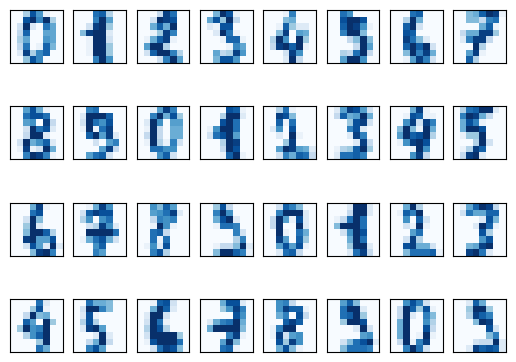

In [3]:
from dl1 import gallery

print(f"Anzahl Datensätze : {len(X)}")
rows, cols = 4, 8
gallery(images,rows, cols,cmap='Blues') 
print(f"y: {y[:rows * cols]}")

Die Variable __X__ enthält die Rohdaten dieser Bilder als Grauwerte zwischen 0 und 255. Die einzelnen Bilder sind 8 Pixel breit und 8 Pixel hoch, enthalten also je 64 Werte. Unsere Software soll in der Lage sein, bei Eingabe eines Arrays aus 64 Werten zwischen 0 und 255 zu entscheiden, welche Ziffer es darstellen soll.

### Mustererkennung und Klassifizierung

Die Erkennung handgeschriebener Ziffern ist ein klassisches Problem in der Künstlichen Intelligenz und der __Mustererkennung__. Ziel ist es, ein System zu entwickeln, das anhand eines Bildes einer handgeschriebenen Ziffer (z. B. "7") die entsprechende Zahl (in diesem Fall "7") korrekt identifiziert. Dabei ist klar, dass es zahlreiche Probleme zu beachten gilt:

* Variabilität der Handschrift: Menschen schreiben Ziffern unterschiedlich. Die Formen, Größen, Neigungen und Strichstärken variieren stark, je nach Person, Schreibstil und Kontext.
* Rauschen und Störungen: Handgeschriebene Ziffern können durch ungleichmäßigen Untergrund, Flecken oder Unsauberkeiten im Schreibprozess beeinträchtigt sein.
* Unterschiedliche Kontexte: Manche Ziffern können schwer zu unterscheiden sein (z. B. "1" und "7" oder "0" und "6"), abhängig von ihrer Darstellung.

### "Normale" Programmierung

Normale (deterministische) Programmierung basiert auf fest definierten Regeln und Entscheidungsbäumen. Bei der Erkennung handgeschriebener Ziffern ist es schwierig, solche Regeln zu formulieren, unter anderem aus folgenden Gründen:

* Zu viele mögliche Variationen: Es ist nahezu unmöglich, alle möglichen Variationen von "2" oder "8" als Regeln in Code zu schreiben.
* Fehlende Eindeutigkeit: Manche Ziffern sind in bestimmten Schreibstilen schwer voneinander zu unterscheiden. Ein Regelwerk müsste sehr komplex sein, um diese Unterscheidung zu treffen.
* Unklare Grenzen: Oft sind Übergänge zwischen ähnlichen Ziffern (wie "4" und "9") fließend. Eine programmatische Beschreibung dieser Graubereiche wäre extrem aufwendig.
* Anpassung an neue Daten: Handgeschriebene Ziffern variieren je nach Kultur oder Zeit, sodass neue Regeln ständig hinzugefügt werden müssten.

__Aufgabe__: Überlegen Sie einmal 5 Minuten lang, wie Sie diese Aufgabe mit normaler Programmierung angehen würden. Haben Sie Ideen, wie Sie dem Computer _erklären_ können, eine 2 von einer 5 zu unterscheiden? Wie hoch würden Sie den Aufwand schätzen, einen Algorithmus zu entwickeln und zu implementieren?

### Lösung mit Hilfe von Deep Learning

Mit Methoden der KI, insbesondere mit neuronalen Netzen, können Systeme trainiert werden, solche Muster zu erkennen, ohne dass explizite Regeln programmiert werden müssen. Dazu wird ein Modell anhand vieler Beispiele trainiert (z. B. mit einem Datensatz wie __MNIST__, der Zehntausende handgeschriebene Ziffern enthält). Das System lernt dabei:

* Merkmale und Muster zu erkennen: Ein neuronales Netz kann eigenständig lernen, dass eine "7" oft aus einer horizontalen und einer diagonalen Linie besteht.
* Rauschen und Variabilität zu tolerieren: Durch das Training auf vielen verschiedenen Beispielen wird das Modell robust gegenüber Abweichungen.
* Automatische Anpassung: KI-Modelle können an neue Daten angepasst und mit zusätzlichen Beispielen weitertrainiert werden.
Diese Fähigkeiten machen KI wesentlich effektiver bei der Lösung dieses Problems als normale Programmierung.

Wir werden die Aufgabe nun mit einer Standard-Bibliothek der KI-Entwicklung unter Python lösen.

## Die KI-Bibliothek Scientific Toolkit for Machine Learning

Ein weit verbereitetes Software-Paket für KI in Python ist scikit-learn, das _Scientific Toolkit for Machine Learning_. Es stellt einfach zu nutzende Funktionen für maschinelles Lernen bereit, und beruht auf den bekannten, grundlegenden Bibliotheken __NumPy__, __SciPy__ und __Matplotlib__. Die Bibliothek wurde 2010 veröffentlicht, wird von einer aktiven Community gepflegt und ist zu einem Standardwerkzeug in der Data-Science-Welt geworden. Sie ist ein hervorragendes Werkzeug für Einsteiger und erfahrene Entwickler gleichermaßen.

## Das Multi-Layered Perceptron

Eins der wichtigsten Werkzeuge in der KI ist das __Multi-Layered Perceptron__ (MLP), das bereits seit Jahrzehnten verwendet wird. In diesem Kursus werden wir es selbst implementieren und seine Wirkungsweise genau untersuchen. Hier Jetztt verwenden wir einfach die Implementierung aus scikit-learn:

In [4]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(max_iter=1000)

Hiermit haben wir eine Instanz eines MLPC erzeugt - das 'C' steht für _Classifier_. Die innere Struktur kennen wir noch nicht, aber das ist für die Verwendung auch gar nicht nötig. Wir übergeben nun die Rohdaten und die Labels unseres Handschriften-Datensatzes an das MLP, das eigenständig lernen soll, die entsprechenden Muster zu erkennen. 

Dazu zerlegen wir die vorhandenen Bilddaten in zwei Teile. Wir verwenden zwei Drittel der Daten, um das MLPC zu _trainieren_. Ein Drittel verwenden wir dann, um das Perzeptron hinterher zu testen: Kann es mit dem Erlernten auch Ziffern erkennen, die es noch nicht "gesehen" hat?

In [5]:
sep = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:sep], X[sep:], y[:sep], y[sep:]

mlpc.fit(X_train,y_train)

MLPClassifier(max_iter=1000)

### Test des MLPC

Das war es! Das MLPC hat die übergebenen Daten verwendet, um seine internen Parameter (welche das sind, sehen wir später) anzupassen (engl. _to fit_), um handgeschriebene Ziffern zu erkennen.

Probieren wir es einmal mit den ersten Ziffern der Tedaten aus. Dazu verwenden wir die Funktion __predict__ des MLPC, der wie die Testdaten __X_test__ übergeben, und vergleichen das Ergenbis mit den erwarteten Werten __y_test__:

In [6]:
n = 20
print(f'Erwartet: \t{y_test[:n]}\nTatsächlich:  \t{mlpc.predict(X_test[:n])}')

Erwartet: 	[2 3 4 5 6 7 8 9 0 9 5 5 6 5 0 9 8 9 8 4]
Tatsächlich:  	[2 3 4 5 6 7 8 9 0 9 5 5 6 5 0 9 8 3 8 4]


Die meisten Werte sind korrekt, vielleicht (mit etwa Glück) sogar alle. 

Mit der eingebauten Funktion __score__ lässt sich der Prozentsatz der korrekt erkannten Ziffern bestimmen:

In [7]:
print(f'Score: {mlpc.score(X_test,y_test) :0.1%} ')

Score: 92.5% 


Nach wenigen Sekunden ist das Netzwerk i.d.R. in der Lage, über 90 % der Ziffern korrekt zu erkennen.

Wir können uns die Ziffern, die nicht erkannt worden sind, auch ansehen. Sind sie vielleicht schwer zu erkennen"?

[9 1 1 8 6 7 8 8 9 8 9 3 3 3 3 4 4 7 9 4 9 3 3 3 3 3 3]


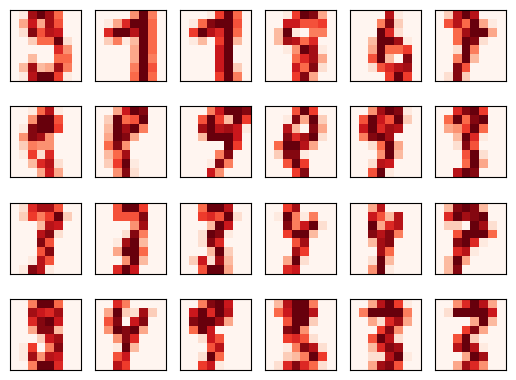

In [8]:
idx = mlpc.predict(X) != y
print(y[idx])
gallery(images[idx],4,6,cmap='Reds')  